In [5]:
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt
import time
from brian2 import *

%matplotlib inline

In [2]:
N_NODES = 200
SPECT_RADIUS = 0.98

trainlen = 2200
future = 1000
buffer = 100

In [3]:
def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x

def step_function(x):
    if x > 0.5:
        return 1
    else:
        return 0
    
def sigmoid(x):
    return 1/(1+np.exp(-10*x+1))


class LI_ESN_internal:

    def __init__(self, n_inputs, n_outputs, n_reservoir=200, W=None, W_in=None,
                 noise=0.001, input_shift=None,
                 input_scaling=None, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, time_scale=None):
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        self.time_scale = time_scale
        self.W = W
        self.W_in = W_in

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand
            
    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _update(self, state, input_pattern):
        # leaky integrator model:
        # it can adjust timescales for each neurons.
        preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        state = (1 - self.time_scale) * state + self.time_scale * np.tanh(preactivation)
        # state = (1 - self.time_scale) * state + self.time_scale * preactivation
        return (state + self.noise * self.time_scale * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def calc_lyapunov_exp(self, inputs, initial_distance, n):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        states1 = np.zeros((inputs.shape[0], self.n_reservoir))
        states2 = np.zeros((inputs.shape[0], self.n_reservoir))
        transient = min(int(inputs.shape[0] / 10), 100)
        for i in range(1, transient):
            states1[i, :] = self._update(states1[i-1], inputs[i, :])
        states2[transient-1, :] = states1[transient-1, :]
        states2[transient-1, n] = states2[transient-1, n] + initial_distance
        gamma_k_list = []
        for k in range(transient, inputs.shape[0]):
            states1[k, :] = self._update(states1[k-1], inputs[k, :])
            states2[k, :] = self._update(states2[k-1], inputs[k, :])
            gamma_k = np.linalg.norm(states2[k, :]-states1[k, :])
            gamma_k_list.append(gamma_k/initial_distance)
            states2[k, :] = states1[k, :] + (initial_distance/gamma_k)*(states2[k, :]-states1[k, :])
        lyapunov_exp = np.mean(np.log(gamma_k_list))
        return lyapunov_exp
            
    
    def fit(self, inputs, outputs):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = outputs

        # step the reservoir through the given input,output pairs:
        self.states = np.zeros((inputs.shape[0], self.n_reservoir))
        # self.states[0] = np.random.rand(self.n_reservoir)*2-1
        for n in range(1, inputs.shape[0]):
            self.states[n, :] = self._update(self.states[n - 1], inputs_scaled[n, :])
        transient = min(int(inputs.shape[0] / 10), 100)
        extended_states = np.hstack((self.states, inputs_scaled))
        
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),teachers_scaled[transient:, :]).T
        # print(self.W_out.shape)

        # remember the last state for later:
        self.laststate = self.states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
            
        # apply learned weights to the collected states:
        pred_train = np.dot(extended_states, self.W_out.T)
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, inputs])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :])
            outputs[n + 1, :] = np.dot(self.W_out,np.concatenate([states[n + 1, :], inputs[n + 1, :]]))

        return self.out_activation(outputs[1:])
        # print(outputs[1:])
        # return np.heaviside(outputs[1:]-0.5, 0)*0.3


In [4]:
def make_layered_network(N, average_degree, community_number, mu):
    assert N % community_number == 0, 'N must be devisible by community_number'
    size = N/community_number
    G = np.zeros((N, N))
    for i in range(N):
        com_index = i//size
        for j in range(N):
            if j <= size*(com_index+1) and j >= size*com_index:
                if i != j and np.random.rand() < average_degree*(1-2*mu)/(size-1):
                    G[i][j] = np.random.randn()
            elif j >= size*(com_index-1) and j <= size*(com_index+2):
                if np.random.rand() < average_degree*mu/size:
                    G[i][j] = np.random.randn()
                    
    return G

In [205]:
def make_data_for_global_switching(length):
    x = np.zeros((2, length+100))
    P = PoissonGroup(1, 30*Hz)
    M = SpikeMonitor(P)
    run((length+100)*ms)
    x[0] = np.random.rand(length+100)*0.5
    for spike_timing in M.t/ms:
        x[1][int(spike_timing)] = 1
    y = np.zeros(length)
    switch = -1
    for t in range(length):
        if x[1][t+100] == 1:
            switch *= -1
        if switch == 1:
            # y[t] = 0.1*(x[0][t-1+100] + x[0][t-3+100] + x[0][t-5+100])
            y[t] = 1
        else:
            # y[t] = -0.1*(x[0][t-1+100] + x[0][t-3+100] + x[0][t-5+100])
            y[t] = -1
    return x, y

In [206]:
def make_data_for_narma(length):
    tau = 0.01
    buffer = 100
    x = np.random.rand(length+100)*0.5
    y = np.zeros(length)
    for i in range(length):
        if i < 29:
            y[i] = 1.5*x[i-29+100]*x[i+100] + 0.001
        else:
            y[i] = 1.5*x[i-29+100]*x[i+100] + 0.001
    return x, y

In [207]:
x, y = make_data_for_global_switching(5000)

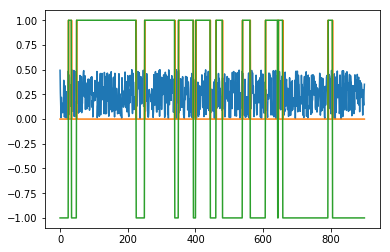

In [208]:
plt.plot(x[0][2300:3200])
plt.plot(x[1][2400:3300])
plt.plot(y[2300:3200])

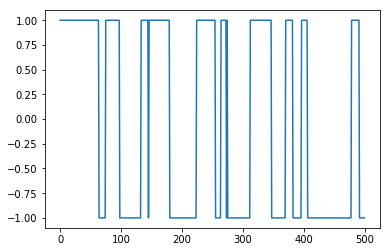

In [209]:
plt.plot(y[1000:1500])

In [210]:
average_degree = 30
mu = 0.2
num_community = 4
community_size = N_NODES//num_community
time_scale = np.ones(N_NODES)*0.65

# time_scale[10:20] = 0.05

W = make_layered_network(N_NODES, average_degree, num_community, mu)
W_IN = (np.random.rand(N_NODES, 2) * 2 - 1)*0.1
W_IN[int(N_NODES/num_community):] = 0
radius = np.max(np.abs(np.linalg.eigvals(W)))
spectral_radius = SPECT_RADIUS
W = W * (spectral_radius / radius)
buffer = 100

data, target = make_data_for_global_switching(5000)
data = data.T

# data, target = make_data_for_narma(5000)



esn = LI_ESN_internal(n_inputs=2,
                      n_outputs=1,
                      n_reservoir=N_NODES,
                      W=W,
                      W_in=W_IN,
                      noise=0,
                      time_scale=time_scale)

pred_training = esn.fit(data[buffer:trainlen+buffer], target[:trainlen])

prediction = esn.predict(data[trainlen+buffer:])
narma = np.sqrt(np.mean((np.reshape(prediction, -1)-np.reshape(target[2200:], -1))**2)/np.var(target[2200:]))

print(narma)


1.0888560122405513


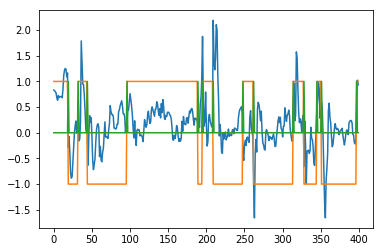

In [211]:
plt.plot(prediction[100:500])
plt.plot(target[2300:2700])
plt.plot(data.T[1][2400:2800])